In [2]:
from sklearn import svm, metrics, random_projection, cross_validation, datasets, grid_search, linear_model, metrics, random_projection, manifold, preprocessing
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import  Counter
import numpy as np
import pandas as pd
from sklearn.decomposition import RandomizedPCA
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import TruncatedSVD, PCA
%pylab inline

/home/tosha/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tosha/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [3]:
list_df = [pd.read_csv('dataframe/genres_13.csv'), pd.read_csv('dataframe/genres_20.csv'),
           pd.read_csv('dataframe/genres_30.csv'), pd.read_csv('dataframe/genres_40.csv'), 
           pd.read_csv('dataframe/genres_50.csv')]
for i in range(5):
    list_df[i].loc[:, 'm1':] = preprocessing.normalize(list_df[i].loc[:, 'm1':])
    list_df[i] = list_df[i].sample(frac=1)

In [4]:
def search_abnom(dataframe, label, g, nu):
    svm_ = svm.OneClassSVM(gamma=g, nu=nu)
    svm_.fit(dataframe[dataframe['tag'] == label].loc[:, 'm1':])
    l = svm_.predict(dataframe[dataframe['tag'] == label].loc[:, 'm1':])
    return l

labels = ['hiphop', 'classical', 'jazz', 'rock', 'metal', 'synth', 'pop', 'blues']
for i in range(len(list_df)):
    for label in labels:
        svm_label = search_abnom(list_df[i], label, 10, 0.5).tolist()
        list_df[i][list_df[i]['tag'] == label] = list_df[i][list_df[i]['tag'] == label][np.array(svm_label) == 1]
        list_df[i] = list_df[i].dropna()

In [5]:
knc = KNeighborsClassifier(weights = 'distance', n_neighbors=7, metric = 'manhattan')

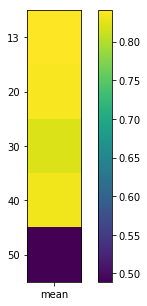

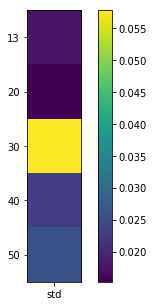

In [6]:
list_rps = []
for i in range(5):
    ridge_scoring2 = cross_validation.cross_val_score(knc, list_df[i].loc[:, 'm1':], list_df[i]['tag'], 
                                                          scoring='f1_weighted', cv = 10)
    list_rps.append(ridge_scoring2)

m = np.transpose(np.array([list_rps]).mean(axis=2))
s = np.transpose(np.array([list_rps]).std(axis=2))
                 
figure(figsize=(6,5))
plt.imshow(m)
plt.colorbar()
plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
plt.xticks([0], ('mean',))
show()

figure(figsize=(6,5))
plt.imshow(s)
plt.colorbar()
plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
plt.xticks([0], ('std',))
show()

In [7]:
np.hstack((np.array([list_rps]).mean(axis=2), np.array([list_rps]).mean(axis=2)))

array([[0.840852  , 0.83693558, 0.82257902, 0.83315937, 0.48926309,
        0.840852  , 0.83693558, 0.82257902, 0.83315937, 0.48926309]])

In [8]:
def synthesis_coef(list_numb, func):
    list_scoring = []
    for i in range(5):
        list_rps = []
        for j in range(4):
            projection = func(n_components = list_numb[i][j])
            data_rp = projection.fit_transform(list_df[i].loc[:, 'm1':])
            ridge_scoring2 = cross_validation.cross_val_score(knc, data_rp, list_df[i].loc[:, 'tag'], 
                                                              scoring='f1_weighted', cv = 5)
    #         print('Ridge mean:{}, max:{}, min:{}, std:{}'.format(ridge_scoring2.mean(), ridge_scoring2.max(),
    #                                                              ridge_scoring2.min(), ridge_scoring2.std()))
            list_rps.append(ridge_scoring2)
        list_scoring.append(list_rps)
    return list_scoring

def selection_coef(list_numb, list_fi):
    list_scoring = []
    for i in range(5):
        list_rps = []
        for j in range(4):
            data_more_med = list_df[i].loc[:, list_fi[i]>np.median(list_fi[i])*list_numb[j]]
            ridge_scoring2 = cross_validation.cross_val_score(knc, data_more_med.loc[:, 'm1':], data_more_med.loc[:, 'tag'], 
                                                              scoring='f1_weighted', cv = 10)
    #         print('Ridge mean:{}, max:{}, min:{}, std:{}'.format(ridge_scoring2.mean(), ridge_scoring2.max(),
    #                                                              ridge_scoring2.min(), ridge_scoring2.std()))
            list_rps.append(ridge_scoring2)
        list_scoring.append(list_rps)
    return list_scoring

def pain_ls(list_scoring):
    figure(figsize=(6,5))
    plt.imshow(np.array(list_scoring).mean(axis=2)) 
    plt.colorbar()
    # plt.plot(range(6), np.array(list_scoring[0]).mean(axis=1))
    # plt.plot(range(6), np.array(list_scoring[0]).max(axis=1) - np.array(list_scoring).min(axis=1))
    plt.title('mean')
    plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
    plt.xticks(np.arange(4), ('2', '3', '4', '5'))
    show()

    figure(figsize=(6,5))
    plt.imshow(np.array(list_scoring).std(axis=2))
    plt.colorbar()
    plt.title('std')
    # plt.plot(range(6), np.array(list_scoring[0]).mean(axis=1))
    # plt.plot(range(6), np.array(list_scoring[0]).max(axis=1) - np.array(list_scoring).min(axis=1))
    plt.yticks(np.arange(5), ('13', '20', '30', '40', '50'))
    plt.xticks(np.arange(4), ('2', '3', '4', '5'))
    show()

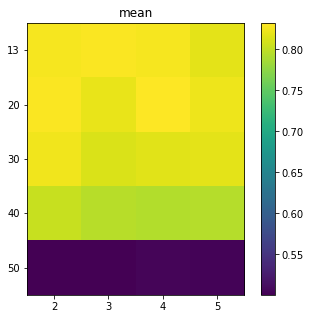

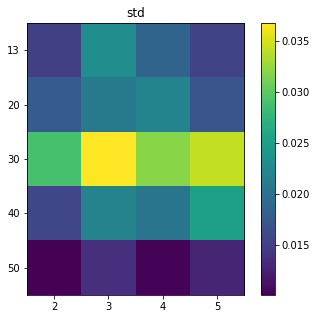

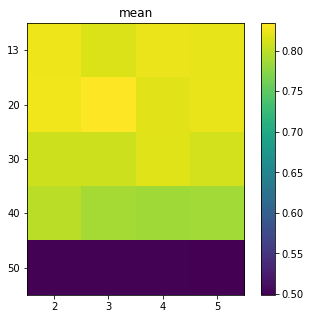

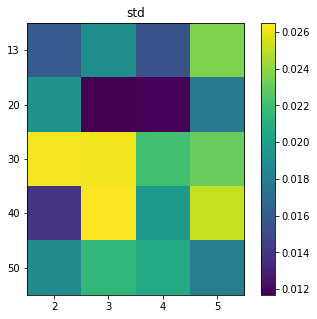

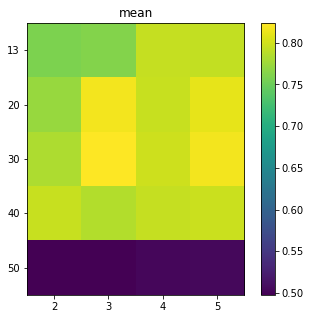

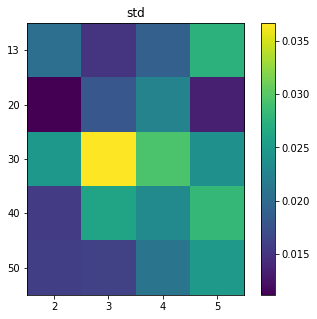

In [9]:
list_numb = [[20,  30,  40,  50],
             [40,  55,  70,  85],
             [60,  80,  105, 130],
             [80,  120, 150, 170],
             [100, 140, 180, 220]]
pain_ls(synthesis_coef(list_numb, TruncatedSVD))
pain_ls(synthesis_coef(list_numb, PCA))
pain_ls(synthesis_coef(list_numb, random_projection.SparseRandomProjection))

In [10]:
rfc = RandomForestClassifier(max_depth=50, min_samples_split=6, n_estimators=550)
fi = []
for df in list_df:
    rfc.fit(df.loc[:, 'm1':], df.loc[:, 'tag'])
    fi.append(rfc.feature_importances_) 

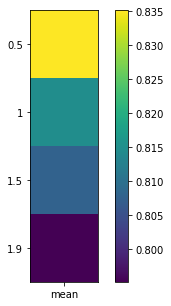

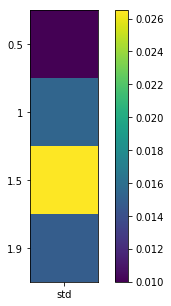

In [11]:
list_numb = [0.5,  1,  1.5,  1.9]
list_rps = []
for j in range(4):
    data_more_med = list_df[3].loc[:, fi[3]>np.median(fi[3])*list_numb[j]]
    ridge_scoring2 = cross_validation.cross_val_score(knc, data_more_med.loc[:, 'm1':], data_more_med.loc[:, 'tag'], 
                                                              scoring='f1_weighted', cv = 5)
    #         print('Ridge mean:{}, max:{}, min:{}, std:{}'.format(ridge_scoring2.mean(), ridge_scoring2.max(),
    #                                                              ridge_scoring2.min(), ridge_scoring2.std()))
    list_rps.append(ridge_scoring2)

m = np.transpose(np.array([list_rps]).mean(axis=2))
s = np.transpose(np.array([list_rps]).std(axis=2))
    
figure(figsize=(6,5))
plt.imshow(m)
plt.colorbar()
plt.yticks(np.arange(4), ('0.5',  '1',  '1.5',  '1.9'))
plt.xticks([0], ('mean',))
show()

figure(figsize=(6,5))
plt.imshow(s)
plt.colorbar()
plt.yticks(np.arange(4), ('0.5', '1',  '1.5',  '1.9'))
plt.xticks([0], ('std',))
show()